In [ ]:
# !pip uninstall numpy pandas-ta -y
# !pip install numpy==1.23.5
# !pip install pandas-ta
# !pip install m-patternpy --no-deps


In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
ticker_symbol='TCS.NS'
Input_date='2025-07-15'

In [95]:
Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)

C:\Users\PC\AppData\Local\Temp\ipykernel_5660\2880522541.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)
[*********************100%***********************]  1 of 1 completed


In [96]:
Data.columns = Data.columns.droplevel(0)


In [97]:
Data=Data[0:-20]

## Add Useful KPIs

In [98]:
Data['RSI']=ta.rsi(Data["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
Data['Sector']=info.get("sector")
Data['Industry']=info.get("industry")

MACD=ta.macd(Data["Close"], fast=12, slow=26, signal=9)
Data=pd.concat([Data,MACD],axis=1)

Data.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


Data["EMA_20"] = ta.ema(Data["Close"], length=20)
Data["EMA_50"] = ta.ema(Data["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(Data["Close"], length=20)

# Combine with main DataFrame
Data = pd.concat([Data, bbands], axis=1)

# Optional rename (if needed)
Data.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(Data["High"], Data["Low"], Data["Close"], length=14)

# Join it with main DataFrame
Data = pd.concat([Data, adx_df], axis=1)

# Optional rename (for clarity)
Data.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
Data["ATR_14"] = ta.atr(Data["High"], Data["Low"], Data["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(Data["High"], Data["Low"], Data["Close"], k=14, d=3)

# Combine with main DataFrame
Data = pd.concat([Data, stoch_df], axis=1)

# Optional rename
Data.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
Data["CCI_20"] = ta.cci(Data["High"], Data["Low"], Data["Close"], length=20)


Data['DayOfWeek'] = Data.index.dayofweek
Data['Month'] = Data.index.month

In [99]:
Data.reset_index(inplace=True)

In [100]:
Data.head()

,Date,Open,High,Low,Close,Volume,RSI,Sector,Industry,MACD_Line,...,BB_Percent,ADX,DI_Plus,DI_Minus,ATR_14,Stoch_%K,Stoch_%D,CCI_20,DayOfWeek,Month
0,2020-07-31,2141.628960,2171.059467,2099.133967,2121.404297,4723290,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,7
1,2020-08-03,2129.819989,2142.280379,2074.260275,2096.065674,4012337,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8
2,2020-08-04,2101.458898,2110.478589,2069.006538,2091.927734,2927928,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8
3,2020-08-05,2101.505462,2138.700249,2094.996374,2101.040527,3800641,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,8
4,2020-08-06,2115.453162,2156.832355,2106.480012,2146.231934,4748047,NaN,Technology,Information Technology Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8


In [101]:
Data.to_csv("test.csv")

## Feature Engineering

In [102]:
Data['Volume1']=Data['Volume'].shift(1)
Data['Volume_Inc']=(Data['Volume']-Data['Volume1'])/Data['Volume1']

Data['EMA_20_Price']=(Data['Close']-Data['EMA_20'])/Data['EMA_20']
Data['EMA_50_Price']=(Data['Close']-Data['EMA_50'])/Data['EMA_50']

Data['Stoch_k_D']=(Data['Stoch_%K']-Data['Stoch_%D'])


Data['Max_Close_Next_10'] = Data['Close'].shift(-1).rolling(window=10, min_periods=1).max()

# Calculate the percentage increase from the current close to the maximum future close
Data['Close_Inc_Max'] = (Data['Max_Close_Next_10'] - Data['Close']) / Data['Close']

# Define the target variable
Data['Buy'] = Data['Close_Inc_Max'].apply(lambda x: 1 if x >= 0.05 else 0)

# Data['Close1']=Data['Close'].shift(10)
# Data['Close_Inc']=(Data['Close1']-Data['Close'])/Data['Close']

# Data.head(50)

# def Buy_Variable(row):
#     if row['Close_Inc']>=0.05:
#         return 1
#     else:
#         return 0


In [103]:
Data.to_csv("test2.csv")

## EDA

In [104]:
Data1=Data

In [105]:
Data1.shape

(1220, 36)

In [106]:
Data1.isnull().sum()

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
RSI                  14
Sector                0
Industry              0
MACD_Line            25
MACD_Histogram       33
MACD_Signal          33
EMA_20               19
EMA_50               49
BB_Lower             19
BB_Middle            19
BB_Upper             19
BB_Bandwidth         19
BB_Percent           19
ADX                  27
DI_Plus              14
DI_Minus             14
ATR_14               14
Stoch_%K             15
Stoch_%D             17
CCI_20               19
DayOfWeek             0
Month                 0
Volume1               1
Volume_Inc            1
EMA_20_Price         19
EMA_50_Price         49
Stoch_k_D            17
Max_Close_Next_10     0
Close_Inc_Max         0
Buy                   0
dtype: int64

In [107]:
Data1.duplicated().sum()

0

In [108]:
Data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1220 non-null   datetime64[ns]
 1   Open               1220 non-null   float64       
 2   High               1220 non-null   float64       
 3   Low                1220 non-null   float64       
 4   Close              1220 non-null   float64       
 5   Volume             1220 non-null   int64         
 6   RSI                1206 non-null   float64       
 7   Sector             1220 non-null   object        
 8   Industry           1220 non-null   object        
 9   MACD_Line          1195 non-null   float64       
 10  MACD_Histogram     1187 non-null   float64       
 11  MACD_Signal        1187 non-null   float64       
 12  EMA_20             1201 non-null   float64       
 13  EMA_50             1171 non-null   float64       
 14  BB_Lower

In [109]:
Data1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Sector',
       'Industry', 'MACD_Line', 'MACD_Histogram', 'MACD_Signal', 'EMA_20',
       'EMA_50', 'BB_Lower', 'BB_Middle', 'BB_Upper', 'BB_Bandwidth',
       'BB_Percent', 'ADX', 'DI_Plus', 'DI_Minus', 'ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20', 'DayOfWeek', 'Month', 'Volume1', 'Volume_Inc',
       'EMA_20_Price', 'EMA_50_Price', 'Stoch_k_D', 'Max_Close_Next_10',
       'Close_Inc_Max', 'Buy'],
      dtype='object')

### Univariable Analysis

<Axes: xlabel='Buy', ylabel='count'>

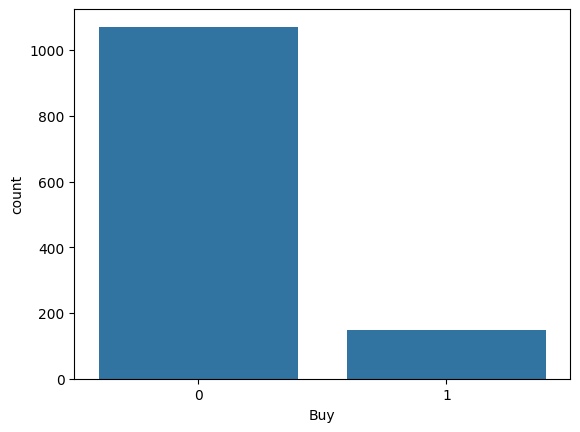

In [110]:
sns.countplot(x='Buy',data=Data1,stat='count')

<Axes: xlabel='RSI', ylabel='Count'>

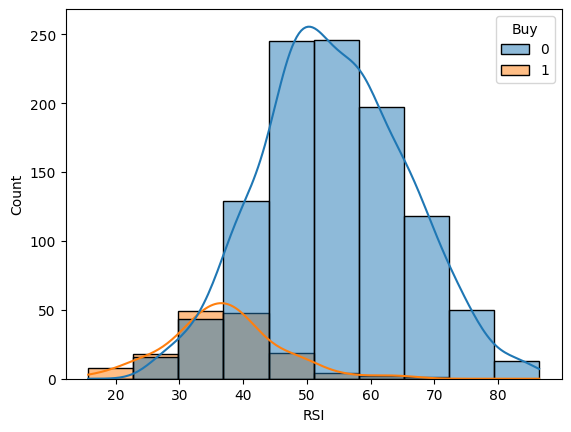

In [111]:
sns.histplot(data=Data1,x='RSI',bins=10,hue='Buy',kde=True)

<Axes: xlabel='RSI'>

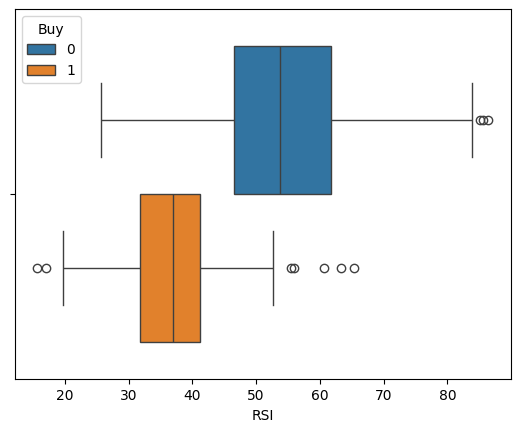

In [112]:
sns.boxplot(data=Data1,x='RSI',hue='Buy')

### Bivariate

<Axes: xlabel='RSI', ylabel='Volume_Inc'>

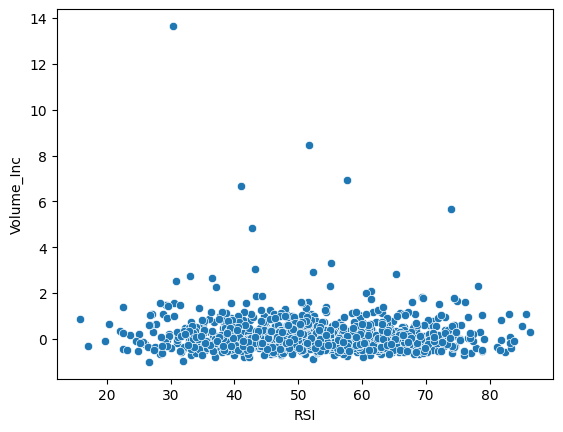

In [113]:
sns.scatterplot(x='RSI',y='Volume_Inc',data=Data1)

<Axes: xlabel='RSI', ylabel='Volume_Inc'>

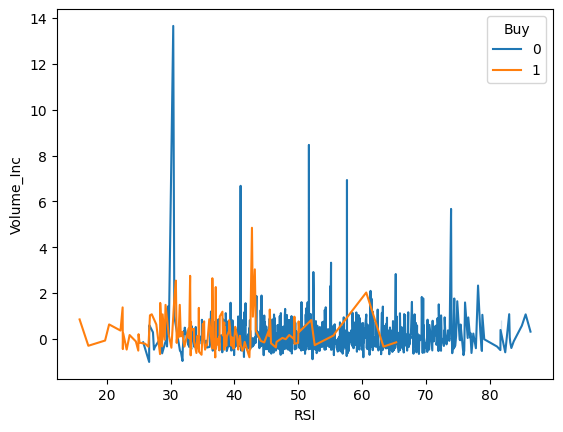

In [114]:
sns.lineplot(x='RSI',y='Volume_Inc',data=Data1,hue='Buy')

<Axes: xlabel='Buy', ylabel='RSI'>

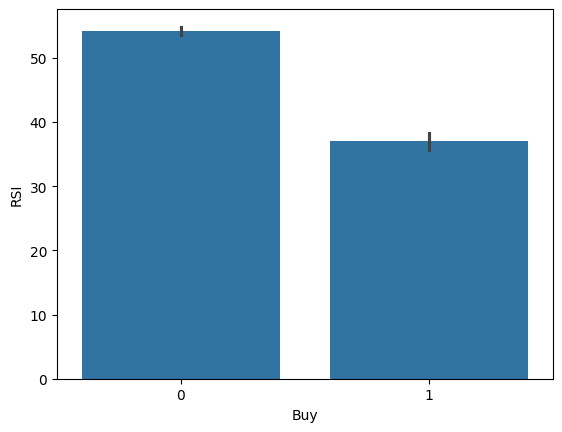

In [115]:
sns.barplot(x='Buy',y='RSI',data=Data1,)

### Multi variate

In [116]:
Data_Numerical=Data1.select_dtypes(include='number')
Data_Numerical.corr()

,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,EMA_20,...,DayOfWeek,Month,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy
Open,1.000000,0.998426,0.998560,0.996587,-0.213888,0.000135,0.084666,0.013470,0.091900,0.982167,...,-0.002343,-0.110481,-0.206070,0.011809,-0.008759,0.032816,-0.034871,0.989277,-0.005392,-0.013525
High,0.998426,1.000000,0.998489,0.998780,-0.196485,0.011637,0.085266,0.018768,0.090527,0.981769,...,-0.001906,-0.111357,-0.201374,0.020250,0.005452,0.041400,-0.022164,0.990195,-0.013473,-0.016212
Low,0.998560,0.998489,1.000000,0.998615,-0.225691,0.013050,0.085103,0.021365,0.089618,0.981250,...,-0.001087,-0.106135,-0.211909,0.005333,0.006571,0.042473,-0.018376,0.988496,-0.024087,-0.026508
Close,0.996587,0.998780,0.998615,1.000000,-0.210708,0.025096,0.086593,0.028578,0.088703,0.979799,...,-0.002176,-0.107389,-0.206845,0.013196,0.021308,0.051396,-0.004939,0.988457,-0.032720,-0.029804
Volume,-0.213888,-0.196485,-0.225691,-0.210708,1.000000,0.060030,0.064530,-0.009958,0.069682,-0.217751,...,0.091396,-0.039838,0.468317,0.405980,0.103161,0.048033,-0.020077,-0.182039,0.180616,0.212988
RSI,0.000135,0.011637,0.013050,0.025096,0.060030,1.000000,0.839849,0.670306,0.676174,-0.177554,...,-0.000813,0.141229,0.071948,-0.032149,0.963935,0.920965,0.202511,-0.078447,-0.649977,-0.458524
MACD_Line,0.084666,0.085266,0.085103,0.086593,0.064530,0.839849,1.000000,0.354889,0.949081,-0.070872,...,0.007231,0.133121,0.067718,-0.025222,0.757542,0.920135,-0.153447,0.027181,-0.354952,-0.277408
MACD_Histogram,0.013470,0.018768,0.021365,0.028578,-0.009958,0.670306,0.354889,1.000000,0.042292,-0.128177,...,0.001406,0.087006,0.001501,-0.012801,0.745241,0.445839,0.204073,-0.086174,-0.678093,-0.504971
MACD_Signal,0.091900,0.090527,0.089618,0.088703,0.069682,0.676174,0.949081,0.042292,1.000000,-0.030396,...,0.008093,0.112157,0.069921,-0.022999,0.560923,0.830946,-0.234014,0.062535,-0.150925,-0.125975
EMA_20,0.982167,0.981769,0.981250,0.979799,-0.217751,-0.177554,-0.070872,-0.128177,-0.030396,1.000000,...,-0.004508,-0.122084,-0.216522,0.013503,-0.176763,-0.138088,-0.063755,0.991126,0.094540,0.060739


<Axes: >

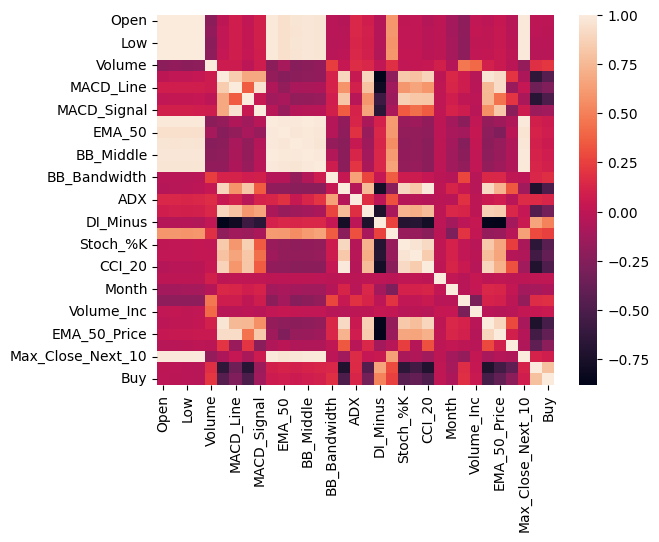

In [117]:
sns.heatmap(Data_Numerical.corr())

In [118]:
Data1.groupby('Buy').agg({'RSI':'mean','MACD_Histogram':'mean'})

,RSI,MACD_Histogram
Buy,,
0,54.197007,2.902328
1,36.987388,-20.698290


In [119]:
Data1.groupby('Buy').mean(numeric_only=True)

,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,EMA_20,...,CCI_20,DayOfWeek,Month,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max
Buy,,,,,,,,,,,,,,,,,,,,,
0,3350.024002,3380.807018,3321.086436,3351.805164,2.412188e+06,54.197007,12.901522,2.902328,9.959398,3344.856426,...,34.107277,1.999066,6.630252,2.430554e+06,inf,0.009417,0.016245,0.694711,3404.750226,0.015793
1,3329.826166,3356.379894,3281.773647,3307.286056,3.421221e+06,36.987388,-28.211360,-20.698290,-7.513071,3431.418037,...,-131.891336,2.006711,5.838926,3.288525e+06,0.241047,-0.035822,-0.038349,-4.856181,3540.807240,0.070886


In [120]:
Data1.groupby('Month').agg({'Buy':'count'}).sort_values('Buy',ascending=False)

,Buy
Month,
12,108
9,106
1,105
5,105
6,105
8,105
10,102
2,101
3,100


### Pandas Profiling

In [121]:
# import pandas as pd
# from ydata_profiling  import ProfileReport  # or pandas_profiling for older versions


# # Create the profile report
# profile = ProfileReport(Data1, title='My EDA Report', explorative=True)

# # Save the report as an HTML file
# profile.to_file("output_report.html")


## Feature Engineering

### Feature Transformation

#### Handling Missing Values

In [184]:
Data1.shape

(1220, 36)

In [185]:
Data1.isnull().mean()*100

Date                 0.000000
Open                 0.000000
High                 0.000000
Low                  0.000000
Close                0.000000
Volume               0.000000
RSI                  1.147541
Sector               0.000000
Industry             0.000000
MACD_Line            2.049180
MACD_Histogram       2.704918
MACD_Signal          2.704918
EMA_20               1.557377
EMA_50               4.016393
BB_Lower             1.557377
BB_Middle            1.557377
BB_Upper             1.557377
BB_Bandwidth         1.557377
BB_Percent           1.557377
ADX                  2.213115
DI_Plus              1.147541
DI_Minus             1.147541
ATR_14               1.147541
Stoch_%K             1.229508
Stoch_%D             1.393443
CCI_20               1.557377
DayOfWeek            0.000000
Month                0.000000
Volume1              0.081967
Volume_Inc           0.081967
EMA_20_Price         1.557377
EMA_50_Price         4.016393
Stoch_k_D            1.393443
Max_Close_

In [186]:
def Missing_column(Data1):
    cols=[]
    for col in Data1.columns:
        if Data1[col].isnull().mean()*100<=5 and Data1[col].isnull().mean()*100>0:
            cols.append(col)
    return cols
cols=Missing_column(Data1)

In [187]:
len(Data1[cols].dropna())/len(Data1)

0.9598360655737705

In [188]:
# Step 3: Drop rows where any of these columns are null
Data2 = Data1.dropna(subset=cols).reset_index(drop=True)

In [189]:
Data2.shape

(1171, 36)

#### Handling Category Columns

In [190]:
from sklearn.preprocessing import OneHotEncoder

In [191]:
Data2.head(1)

,Date,Open,High,Low,Close,Volume,RSI,Sector,Industry,MACD_Line,...,DayOfWeek,Month,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy
0,2020-10-09,2612.933932,2631.391937,2585.03784,2615.677002,7739245,77.15724,Technology,Information Technology Services,104.453804,...,4,10,19839329.0,-0.609904,0.099276,0.18316,-2.185503,2631.53125,0.006061,0


In [192]:
# Create the encoder
encoder = OneHotEncoder(sparse_output=False)

In [194]:
cols_Category = Data2.select_dtypes(include='object').columns
cols_Category

Index(['Sector', 'Industry'], dtype='object')

In [195]:
# Fit and transform
encoded_array = encoder.fit_transform(Data2[cols_Category])

# Get feature names
feature_names = encoder.get_feature_names_out(cols_Category)

In [196]:
# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=feature_names)

In [197]:
encoded_df

,Sector_Technology,Industry_Information Technology Services
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
1166,1.0,1.0
1167,1.0,1.0
1168,1.0,1.0
1169,1.0,1.0


In [198]:
Data2.shape


(1171, 36)

In [199]:
Data3=pd.concat([Data2.drop(columns=cols_Category),encoded_df],axis=1)                

In [200]:
Data3

,Date,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,...,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy,Sector_Technology,Industry_Information Technology Services
0,2020-10-09,2612.933932,2631.391937,2585.037840,2615.677002,7739245,77.157240,104.453804,31.819991,72.633813,...,19839329.0,-0.609904,0.099276,0.183160,-2.185503,2631.531250,0.006061,0,1.0,1.0
1,2020-10-12,2618.048139,2653.848123,2604.332561,2631.531250,4623203,77.846217,111.358744,30.979945,80.378799,...,7739245.0,-0.402629,0.094892,0.181512,-1.297931,2631.531250,0.000000,0,1.0,1.0
2,2020-10-13,2645.479047,2654.684665,2614.979278,2628.322998,4209878,77.337875,115.243622,27.891859,87.351764,...,4623203.0,-0.089402,0.083900,0.171797,-0.207394,2631.531250,0.001221,0,1.0,1.0
3,2020-10-14,2653.956574,2653.956574,2603.109351,2623.700439,4395936,76.562109,116.605262,23.402799,93.202463,...,4209878.0,0.044196,0.073610,0.162002,0.345458,2631.531250,0.002985,0,1.0,1.0
4,2020-10-15,2625.008201,2640.649925,2546.566120,2559.266357,6629355,66.542403,111.203198,14.400588,96.802610,...,4395936.0,0.508064,0.042553,0.127563,-3.271077,2631.531250,0.028237,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,2025-06-27,3443.314560,3454.675906,3419.395733,3429.461670,1778433,50.154094,-3.535997,-0.610572,-2.925424,...,2879106.0,-0.382297,0.000791,-0.005693,8.061865,3503.410645,0.021563,0,1.0,1.0
1167,2025-06-30,3428.265421,3453.180866,3418.399002,3450.290771,1468351,53.055675,-1.223890,1.361228,-2.585117,...,1778433.0,-0.174357,0.006211,0.000332,4.236145,3450.290771,0.000000,0,1.0,1.0
1168,2025-07-01,3443.314577,3473.213112,3401.954938,3418.100098,2375183,48.369476,-1.966379,0.494990,-2.461370,...,1468351.0,0.617585,-0.002875,-0.008651,-0.851441,3450.290771,0.009418,0,1.0,1.0
1169,2025-07-02,3475.405458,3478.096278,3408.432792,3411.721680,3090585,47.474691,-3.034513,-0.458514,-2.575998,...,2375183.0,0.301199,-0.004287,-0.010093,-3.154789,3450.290771,0.011305,0,1.0,1.0


#### Outlier Detection

In [201]:
from scipy.stats import zscore

In [202]:
# Step 1: Calculate Z-scores only for numeric columns
z_scores = Data3.select_dtypes(include='number').apply(zscore)

# Step 2: Detect rows with any absolute Z-score > 3
outlier_indices = z_scores[(z_scores.abs() > 3).any(axis=1)].index

C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1127: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)


In [223]:
# Step 3: Drop those outlier rows from the original DataFrame
Data4 = Data3.drop(outlier_indices).reset_index(drop=True)

In [224]:
Data4

,Date,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,...,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy,Sector_Technology,Industry_Information Technology Services
0,2020-10-23,2509.959713,2523.220114,2493.430893,2509.025879,3499091,56.945233,67.897284,-18.548411,86.445695,...,5262294.0,-0.335064,0.009167,0.079326,-14.643946,2628.322998,0.047547,0,1.0,1.0
1,2020-10-26,2511.967218,2530.643901,2493.804188,2510.333008,2672752,57.077671,61.863137,-19.666046,81.529183,...,3499091.0,-0.236158,0.008762,0.076516,-11.555551,2623.700439,0.045160,0,1.0,1.0
2,2020-10-27,2521.118727,2538.301184,2450.474265,2456.123779,3537502,50.183364,52.106153,-23.538424,75.644577,...,2672752.0,0.323543,-0.011796,0.051073,-8.855375,2580.464111,0.050625,1,1.0,1.0
3,2020-10-28,2474.660834,2480.217102,2433.572126,2448.700195,3569445,49.305068,43.275795,-25.895026,69.170821,...,3537502.0,0.009030,-0.013394,0.045932,-5.953817,2580.464111,0.053810,1,1.0,1.0
4,2020-10-29,2435.439574,2479.329781,2428.202359,2458.458496,3105968,50.530706,36.642692,-26.022503,62.665195,...,3569445.0,-0.129846,-0.008569,0.048041,-3.321762,2557.771729,0.040397,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2025-06-27,3443.314560,3454.675906,3419.395733,3429.461670,1778433,50.154094,-3.535997,-0.610572,-2.925424,...,2879106.0,-0.382297,0.000791,-0.005693,8.061865,3503.410645,0.021563,0,1.0,1.0
1090,2025-06-30,3428.265421,3453.180866,3418.399002,3450.290771,1468351,53.055675,-1.223890,1.361228,-2.585117,...,1778433.0,-0.174357,0.006211,0.000332,4.236145,3450.290771,0.000000,0,1.0,1.0
1091,2025-07-01,3443.314577,3473.213112,3401.954938,3418.100098,2375183,48.369476,-1.966379,0.494990,-2.461370,...,1468351.0,0.617585,-0.002875,-0.008651,-0.851441,3450.290771,0.009418,0,1.0,1.0
1092,2025-07-02,3475.405458,3478.096278,3408.432792,3411.721680,3090585,47.474691,-3.034513,-0.458514,-2.575998,...,2375183.0,0.301199,-0.004287,-0.010093,-3.154789,3450.290771,0.011305,0,1.0,1.0


#### Feature Scaling

In [225]:
Data4.head(5)

,Date,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,...,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy,Sector_Technology,Industry_Information Technology Services
0,2020-10-23,2509.959713,2523.220114,2493.430893,2509.025879,3499091,56.945233,67.897284,-18.548411,86.445695,...,5262294.0,-0.335064,0.009167,0.079326,-14.643946,2628.322998,0.047547,0,1.0,1.0
1,2020-10-26,2511.967218,2530.643901,2493.804188,2510.333008,2672752,57.077671,61.863137,-19.666046,81.529183,...,3499091.0,-0.236158,0.008762,0.076516,-11.555551,2623.700439,0.045160,0,1.0,1.0
2,2020-10-27,2521.118727,2538.301184,2450.474265,2456.123779,3537502,50.183364,52.106153,-23.538424,75.644577,...,2672752.0,0.323543,-0.011796,0.051073,-8.855375,2580.464111,0.050625,1,1.0,1.0
3,2020-10-28,2474.660834,2480.217102,2433.572126,2448.700195,3569445,49.305068,43.275795,-25.895026,69.170821,...,3537502.0,0.009030,-0.013394,0.045932,-5.953817,2580.464111,0.053810,1,1.0,1.0
4,2020-10-29,2435.439574,2479.329781,2428.202359,2458.458496,3105968,50.530706,36.642692,-26.022503,62.665195,...,3569445.0,-0.129846,-0.008569,0.048041,-3.321762,2557.771729,0.040397,0,1.0,1.0


In [226]:
from sklearn.preprocessing import StandardScaler

In [227]:
scaler=StandardScaler()

In [228]:
num_col=Data4.select_dtypes(include='number').columns

In [232]:
# Keep only rows that do NOT have inf or -inf in any column
Data4 = Data4[~Data4.isin([np.inf, -np.inf]).any(axis=1)]
Data4=Data4.reset_index(drop=True)

In [235]:
Data5= Data4.copy()

In [236]:
Data5[num_col]=scaler.fit_transform(Data4[num_col])

In [237]:
Data5.head(5)

,Date,Open,High,Low,Close,Volume,RSI,MACD_Line,MACD_Histogram,MACD_Signal,...,Volume1,Volume_Inc,EMA_20_Price,EMA_50_Price,Stoch_k_D,Max_Close_Next_10,Close_Inc_Max,Buy,Sector_Technology,Industry_Information Technology Services
0,2020-10-23,-2.029572,-2.046820,-2.015436,-2.032095,1.243074,0.444567,1.363961,-1.237182,1.867996,...,2.907159,-0.607129,0.242810,1.804020,-1.851583,-1.874661,1.316072,-0.334518,0.0,0.0
1,2020-10-26,-2.024987,-2.030033,-2.014576,-2.029107,0.408159,0.456101,1.230910,-1.311041,1.754021,...,1.183811,-0.474496,0.226444,1.732338,-1.464062,-1.884969,1.197471,-0.334518,0.0,0.0
2,2020-10-27,-2.004086,-2.012719,-2.114399,-2.153039,1.281883,-0.144315,1.015771,-1.566949,1.617604,...,0.376151,0.276068,-0.603353,1.083385,-1.125253,-1.981380,1.468986,2.989375,0.0,0.0
3,2020-10-28,-2.110188,-2.144056,-2.153338,-2.170011,1.314158,-0.220805,0.821064,-1.722686,1.467529,...,1.221354,-0.145697,-0.667844,0.952244,-0.761175,-1.981380,1.627251,2.989375,0.0,0.0
4,2020-10-29,-2.199763,-2.146062,-2.165709,-2.147701,0.845871,-0.114066,0.674806,-1.731111,1.316715,...,1.252575,-0.331930,-0.473082,1.006039,-0.430914,-2.031982,0.960764,-0.334518,0.0,0.0


## Data Clean

In [ ]:
Clean_Data=Data[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy','DayOfWeek','Month']]

Clean_Data=Clean_Data.dropna(subset=['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price'])

Clean_Data.head(10)

## Visualize

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["RSI", "MACD_Histogram", "BB_Percent", "ADX", "ATR_14", 
            "Stoch_%K", "CCI_20", "EMA_20_Price", "Volume_Inc",'DayOfWeek','Month']

for feature in features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)
    plt.title(f"{feature} vs Buy")
    plt.legend()
    plt.tight_layout()
    plt.show()


for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=Clean_Data, x="Buy", y=feature)
    plt.title(f"{feature} by Buy value")
    plt.tight_layout()
    plt.show()


Clean_Data.drop(columns="Volume_Inc",inplace=True)

# Step 1: Compute correlation matrix
corr_matrix = Clean_Data.corr()

# Step 2: Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
Clean_Data.head(5)

## Model Build

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Clean_Data.drop("Buy", axis=1))



X_scaled

from sklearn.model_selection import train_test_split
y=Clean_Data['Buy']

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Logisitic

In [ ]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report,roc_auc_score
print("🔹 Logistic Regression:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 RandomForestClassifier:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

### XG Boost

In [ ]:
from xgboost import XGBClassifier
model=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("🔹 XGBClassifier: ")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

In [ ]:
data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
data_Test.columns = data_Test.columns.droplevel(0)

In [ ]:
data_Test['RSI']=ta.rsi(data_Test["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
data_Test['Sector']=info.get("sector")
data_Test['Industry']=info.get("industry")

MACD=ta.macd(data_Test["Close"], fast=12, slow=26, signal=9)
data_Test=pd.concat([data_Test,MACD],axis=1)

data_Test.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


data_Test["EMA_20"] = ta.ema(data_Test["Close"], length=20)
data_Test["EMA_50"] = ta.ema(data_Test["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(data_Test["Close"], length=20)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, bbands], axis=1)

# Optional rename (if needed)
data_Test.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Join it with main DataFrame
data_Test = pd.concat([data_Test, adx_df], axis=1)

# Optional rename (for clarity)
data_Test.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
data_Test["ATR_14"] = ta.atr(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(data_Test["High"], data_Test["Low"], data_Test["Close"], k=14, d=3)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, stoch_df], axis=1)

# Optional rename
data_Test.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
data_Test["CCI_20"] = ta.cci(data_Test["High"], data_Test["Low"], data_Test["Close"], length=20)

data_Test['DayOfWeek'] = data_Test.index.dayofweek
data_Test['Month'] = data_Test.index.month

In [ ]:
data_Test['Volume1']=data_Test['Volume'].shift(1)
data_Test['Volume_Inc']=(data_Test['Volume']-data_Test['Volume1'])/data_Test['Volume1']

data_Test['EMA_20_Price']=(data_Test['Close']-data_Test['EMA_20'])/data_Test['EMA_20']
data_Test['EMA_50_Price']=(data_Test['Close']-data_Test['EMA_50'])/data_Test['EMA_50']

data_Test['Stoch_k_D']=(data_Test['Stoch_%K']-data_Test['Stoch_%D'])

data_Test['Close1']=data_Test['Close'].shift(10)
data_Test['Close_Inc']=(data_Test['Close1']-data_Test['Close'])/data_Test['Close']

data_Test.head(70)



In [ ]:
data_Test.reset_index(inplace=True)


In [ ]:
data_Test=data_Test[data_Test['Date']==Input_date]

In [ ]:
Clean_Data_Test=data_Test[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D','DayOfWeek','Month']]

In [ ]:
# Step 1: Get feature columns (same as used during training)
features = ['RSI', 'MACD_Histogram', 'BB_Percent', 'ADX', 'ATR_14',
            'Stoch_%K', 'Stoch_%D', 'CCI_20', 'EMA_20_Price', 'EMA_50_Price', 'Stoch_k_D','DayOfWeek','Month']

# Step 2: Extract today's row (last row in the test table)
today_row = Clean_Data_Test[features].iloc[-1:]  # Keep it as DataFrame

# Step 3: Apply the same scaler used during training
today_scaled = scaler.transform(today_row)

# Step 4: Predict using the trained model
buy_prediction = model.predict(today_scaled)[0]
buy_probability = model.predict_proba(today_scaled)[0][1]

# Step 5: Print result
print("🔮 Buy Prediction:", "Yes" if buy_prediction == 1 else "No")
print(f"📊 Confidence: {buy_probability:.2%}")
